*Do not delete this style setting*

In [1]:
%%html
<style>
table {float:left}
</style>

# Session 3<br> A Simple Classical Classifier

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To create a simple classical classifier in <strong>PyTorch</strong><br>
            and compare its workings with the equivalent quantum classifier.</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the following two datasets from UCI repository (require: pip install ucimlrepo):<br>
            <ol><li><a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>:
              This is a database of automobile specs. The aim is to determine its insurance risk (symboling). Data loading and preprocessing was included below.</li>
            <li><a href="https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks" target="_blank">Sonar</a>:
              The aim is to discriminate between sonar signals bounced off a mine (metal cylinder) or a rock (roughly cylindrical).</li>
            </ol></td></tr>
    <tr><td><strong>Tasks:</strong></td>
        <td>40 minutes (unfinished tasks go to self-directed "challenges")</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks<br>(not applicable to this "classical" notebook):<br>
        <ol>
            <li>Initially use the <strong><em>Automobiles</em></strong> dataset 1 (as provided).<br>
                Follow the instructor demonstration to step through the code.<br>
                - we will first look at a classical PyTorch model<br>
                - and then look at the quantum PyTorch+PennyLane model.</li>
            <li>Explore your dataset and think of its impact on the process and results:<br>
                - hint: consider data ordering and what needs to be done about it</li>
            <li>Can you improve the model performance by changing the approach<br>to dimensionality reduction:<br>
                - feature selection based on intuition (default) ?<br>
                - feature selection based on Chi2 ?<br>
                - dimensionality reduction based on PCA ?<br>
                Which of these approaches had the greatest impact on performance?</li>
            <li>Improve the model performance.<br>
                - changes may apply to data, model and its training<br>
                - what methods have you applied and with what result ?</li>
            <li>Create some data on the fantasy automobiles and use the developed model for<br>
                their classification. Does it match your expectation?</li>
            <li>Compare the classical vs quantum classification models and their performance.</li>
            <li>Reflect on this session.</li>
        </ol></td>
    </tr>
    <tr>
        <td><strong>Challenge<br>Tasks:</strong></td>
        <td>Perform one or more of the following tasks in your own time:<br/>
        <ol style="list-style-type: upper-alpha;">
            <li>Complete the unfinished tasks.</li>
            <li>Incorporate custom initialisation of your model (research).</li>
            <li>Change the quantum model by incorporating a full-reuploading ansatz.</li>
            <li>Include the quantum model definition as part of the <strong><em>Quantum_Auto</em></strong> class.</li>
            <li>Change (back) the label variable from binary to multiclass (hard), <br>
                to implement and test a multinomial classification model (research).</li>
            <li>Apply your completed model to the <strong><em>Sonar</em></strong> data set 2</li>
        </ol></td>
    </tr>
    <tr><td><strong>References:</strong></td>
        <td><ul>
            <li><a href = "https://www.youtube.com/watch?v=OIenNRt2bjg" target="_blank">
                AssemblyAI, “PyTorch Crash Course - Getting Started with Deep Learning”,<br>YouTube Video, Jul 2022.</a></li>
            <li><a href = "https://pennylane.ai/qml/demos/tutorial_qnn_module_torch" target="_blank">Thomas Bromley, "Turning quantum nodes into Torch Layers",<br>
                PennyLane Demo, October 7, 2024.</a></li>
            <li><a href = "https://docs.pennylane.ai/en/stable/code/api/pennylane.qnn.TorchLayer.html" target="_blank">PennyLane, "qml.qnn.TorchLayer",<br>
                PennyLane Documentation, Code API, 2025.</a></li>
            <li><a href = "https://pennylane.ai/qml/demos/tutorial_local_cost_functions" target="_blank">Thomas Storwick, "Alleviating barren plateaus with local cost functions",<br>
                PennyLane Tutorial, November 6, 2024.</a></li>
        </ul></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="https://creativecommons.org/licenses/by/4.0/" target="_blank">Creative Commons CC-BY</a></td></tr>
</table>

## Libraries

In [2]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/lib/python311.zip',
 '/home/jacob/miniconda3/lib/python3.11',
 '/home/jacob/miniconda3/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/venv/pl-gpu/lib/python3.11/site-packages',
 '.']

In [3]:
### General libraries

import os
import pylab
import math
import time
import copy
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
### Import utilities
from utilities import multi_plot_hist, multi_plot_series, draw_circuit

In [5]:
### Import PennyLane and Torch
import pennylane as qml
from pennylane import numpy as np
from pennylane import NesterovMomentumOptimizer
from torch import nn
from torch.autograd import Variable
import torch

---

## <font color="blue">Data preparation</font>

Selected dataset: <a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>.
  
<font color="CornflowerBlue">_**Data needs to be prepared as follows:**_</font>

- <font color="CornflowerBlue">*Load and understand data*</font>
- <font color="CornflowerBlue">*Select numerical variables only (make it simple)*</font>
- <font color="CornflowerBlue">*Eliminate missing values*</font>
- <font color="CornflowerBlue">*Prepare the label (change it to binary)*</font>
- <font color="CornflowerBlue">*Standardise predictors*</font>
- <font color="CornflowerBlue">*Reduce dimensionality*</font>

In [6]:
### Dataset settings
n_features = 5
data_seed = 42

### Load and understand data

In [7]:
from ucimlrepo import fetch_ucirepo

auto = fetch_ucirepo(id=10)
X_vars = auto.data.features 
y_class = auto.data.targets 
print(auto.metadata['additional_info']['summary'],'\n') 

This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.  The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price.   Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale.  Actuarians call this process "symboling".  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year.  This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute. 



In [8]:
X_vars.head(5)

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,length,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,171.2,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,176.6,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,176.6,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0


### Preliminary data processing

In [9]:
### After a brief investigation, it is evident that ...
#   this data set has a serious problem and cannot be used as it is!
...

Ellipsis

### Select numerical predictors only

In [10]:
### Select numeric columns only
X_sel = X_vars.select_dtypes(include=np.number)
X_sel.columns

Index(['price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower',
       'compression-ratio', 'stroke', 'bore', 'engine-size',
       'num-of-cylinders', 'curb-weight', 'height', 'width', 'length',
       'wheel-base', 'num-of-doors', 'normalized-losses'],
      dtype='object')

### Deal with missing values

In [11]:
### Identify columns with missing values
X_sel.isna().sum().loc[lambda x : x > 0].sort_index()

bore                  4
horsepower            2
normalized-losses    41
num-of-doors          2
peak-rpm              2
price                 4
stroke                4
dtype: int64

In [12]:
### Replace missing values with column mean
#   Then check that missing values have been eliminated
auto_xmean = X_sel.mean()
X_sel = X_sel.fillna(auto_xmean)
X_sel.isna().sum().loc[lambda x : x > 0]

Series([], dtype: int64)

### Standardise predictors

In [13]:
# Standardise all variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler
auto_scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled = auto_scaler.fit_transform(X_sel) 
X_std = pd.DataFrame(scaled, columns=X_sel.columns)
# multi_plot_hist(X_std, n_cols = 5, figsize=(8,5.5));

### Prepare the label
<font color="CornflowerBlue">As the label is numeric and multi-class, to simplify the task we turn the label into a binary variable.<br>
The binary class split will be around the distribution mean.</font>

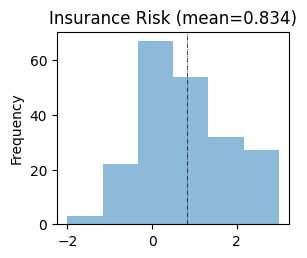

In [14]:
### Observe label distribution
auto_ymean = y_class["symboling"].mean()
ax = y_class.plot.hist(bins=6, alpha=0.5, title=f'Insurance Risk (mean={round(auto_ymean, 3)})', 
                       figsize=(3,2.5))
ax.get_legend().remove()
plt.axvline(auto_ymean, color='k', linestyle='-.', linewidth=0.5);

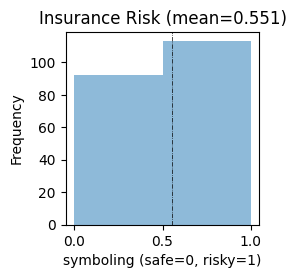

In [15]:
### Create a binary label
pd.set_option('display.max_rows', 10)
y_std = pd.DataFrame(y_class)
y_std['symboling'] = np.where(y_std['symboling'] > auto_ymean, 1, 0)
y_binmean = y_std["symboling"].mean()

ax = y_std.plot.hist(bins=2, alpha=0.5, title=f'Insurance Risk (mean={np.round(y_binmean, 3)})', 
                 figsize=(2.5,2.5))
ax.set_xlabel(f'{y_std.columns[0]} (safe=0, risky=1)')
ax.get_legend().remove()
plt.axvline(y_binmean, color='k', linestyle='-.', linewidth=0.5);

### Reduce data dimensionality
Note that we should somehow reduce data dimensionality.

In [16]:
### The number of features to select
col_names = list(X_std.columns)
print(f'\nNumber of features available: {X_std.shape[1]}\n'+\
      f'Number of features to select: {n_features}\n\n'+\
      f'Features: {*col_names,}')


Number of features available: 17
Number of features to select: 5

Features: ('price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower', 'compression-ratio', 'stroke', 'bore', 'engine-size', 'num-of-cylinders', 'curb-weight', 'height', 'width', 'length', 'wheel-base', 'num-of-doors', 'normalized-losses')


#### Feature selection based on intuition

In [17]:
X_hunch = X_std[['price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower']]
X_hunch.columns

Index(['price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower'], dtype='object')

#### Feature selection based on statistical analysis (ANOVA F-test or $\chi^2$)

In [18]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Feature extraction
selector = SelectKBest(score_func=f_classif, k=n_features)
X_ext = selector.fit_transform(X_std, y_std)

# Identify selected features
columns_mask = selector.get_support()
sel_features = X_std.columns[columns_mask]
X_kbest = pd.DataFrame(data = X_ext, columns = sel_features)
X_kbest.columns

Index(['curb-weight', 'height', 'length', 'wheel-base', 'num-of-doors'], dtype='object')

#### Dimensionality reduction with PCA

In [19]:
from sklearn.decomposition import PCA

n_components = n_features
auto_pca = PCA(n_components=n_components)
X_pca = auto_pca.fit_transform(X_std)
X_pca = pd.DataFrame(X_pca, columns=[f'PC{n:02d}' for n in range(X_pca.shape[1])])
pca_var = auto_pca.explained_variance_ratio_
print(f'Explained var = {np.sum(pca_var):02.3f}')
X_pca.columns

Explained var = 0.869


Index(['PC00', 'PC01', 'PC02', 'PC03', 'PC04'], dtype='object')

#### Select an approach to dimensionality reduction
<font color="CornflowerBlue">Select the method of dimensionality reduction by copying the required version of X.<br>
All versions have been defined above.</font>

In [20]:
X = X_hunch.copy()
y = y_std.copy()

***

## <font color="blue">Model development</font>

### Utilities

In [21]:
### Performance measures

### A simple MSE cost function
def square_mse(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

### Calculates accuracy from expval predictions
def accuracy(labels, predictions, prec=1e-5):
    acc = sum(abs(l - p) < prec for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc.item()

### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define device to compute on

In [22]:
### Find what devices are available

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\nThe available devices:\t\t{torch_device}')

# Force CPU to avoid moving computation and data back and from the GPU
torch_device = "cpu"

print(f'PyTorch device to be used:\t{torch_device}\n')


The available devices:		cuda:0
PyTorch device to be used:	cpu



### Model and training configuration

In [23]:
### Data params
n_data = X.shape[0]
x_angle_margin = 0.1
x_angle_min = 0+x_angle_margin
x_angle_max = np.pi-x_angle_margin

### Training params
epochs = 400     # 50 # 80 # 100 # 300
log_interv = 1   # History to be saved only once every interv or epochs
acc_prec = 0.5   # Precision of accuracy calculation
shots = None     # None means using theoretical frequency distribution 
seed = 2025

### Prepare data exactly as for the quantum classifier

<font color="CornflowerBlue">Note that we have already scaled the X values to the [0..1] range.<br>
That value range was needed to perform PCA, if this dimensionality reduction was to be used.<br>
We could not scale X to the range of values [0..pi] as required for quantum data encoding,<br>
as PCA would have changed that range later on.</font>

In [24]:
### Standardise X values to the range 0+margin..pi-margin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
scaled = angle_scaler.fit_transform(X) 
X = pd.DataFrame(scaled, columns=X.columns)

In [25]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:n_data], y.iloc[:,0:n_data], 
    test_size=0.33, shuffle=False, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(137, 5), X_test=(68, 5), y_train=(137, 1), y_test=(68, 1)


In [26]:
### Change the data format to tensors
X_train_tens = torch.tensor(np.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(np.array(y_train), dtype=torch.double)
X_test_tens  = torch.tensor(np.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(np.array(y_test), dtype=torch.double)

### PyTorch model with PennyLane layer

<font color="CornflowerBlue">To use PennyLane Torch layers refer to the 
<a href="https://docs.pennylane.ai/en/stable/code/api/pennylane.qnn.TorchLayer.html" target="_blank">TorchLayer PennyLane API</a>
as well as <a href = "https://pennylane.ai/qml/demos/tutorial_qnn_module_torch" target="_blank">Thomas Bromley tute on Torch layers</a>.</font>

In [27]:
### Classic classifier
class Classic_Auto(nn.Module):

    def __init__(self, in_shape, out_shape):
        super(Classic_Auto, self).__init__()

        # self.model = nn.Sequential(
        #     nn.Linear(in_shape, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 8),
        #     nn.ReLU(),
        #     nn.Linear(8, out_shape)
        # )
        
        layers = self.layers(in_shape, out_shape)
        self.model = nn.Sequential(*layers)
        
    def layers(self, in_shape, out_shape):
        
        clayer_0 = torch.nn.Linear(in_shape, 32)
        clayer_1 = torch.nn.ReLU()
        clayer_2 = torch.nn.Linear(32, 64)
        clayer_3 = torch.nn.ReLU()
        clayer_4 = torch.nn.Linear(64, 32)
        clayer_5 = torch.nn.ReLU()
        clayer_6 = torch.nn.Linear(32, 8)
        clayer_7 = torch.nn.ReLU()
        clayer_8 = torch.nn.Linear(8, out_shape)
        
        layers = [clayer_0, clayer_1, clayer_2, clayer_3, clayer_4,
                  clayer_5, clayer_6, clayer_7, clayer_8]
        return layers

    def forward(self, x):
        x = self.model(x)
        return x

### Test the classical PyTorch model before use

In [28]:
### Create a test model and draw the test model circuit
test = Classic_Auto(in_shape=X_train_tens.shape[1], out_shape=y_train_tens.shape[1]).double().to(torch_device)

print(f'\nCM weights: {count_params(test)}, Epochs: {epochs}')
print(f'\nTest results: {test(X_train_tens[0:5])}\n')
test.eval()


CM weights: 4657, Epochs: 400

Test results: tensor([[-0.1898],
        [-0.1894],
        [-0.1843],
        [-0.1876],
        [-0.1882]], dtype=torch.float64, grad_fn=<AddmmBackward0>)



Classic_Auto(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

### Creation and training of the PennyLane/PyTorch model

In [29]:
### Trains a PyTorch model (of any kind)

def train_model(model, X, y, cost_fun, acc_fun, optimizer, epochs, 
                    log_interv=100, prompt_fract=0.1, acc_prec=0.5, start_time=0):
    
    history = []
    acc_hist = []
    opt_params = {}
    hist_params = []
    min_epoch = 0
    min_cost = 1000
    max_acc = -1000
    if start_time == 0: start_time = time.time()
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        acc = acc_fun(output, y, prec=acc_prec)
        cost.backward()
        optimizer.step()

        curr_cost = cost.item()
        curr_acc = acc
        if curr_cost < min_cost: 
            min_cost = curr_cost
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_acc > max_acc:
            max_acc = curr_acc

        if epoch % log_interv == 0:
            history.append(curr_cost)
            acc_hist.append(curr_acc)
            hist_params.append(copy.deepcopy(model.state_dict()))

        elapsed = time.time() - start_time
        if (prompt_fract == 0) or (epoch % int(prompt_fract*epochs) == 0):
            print(f'{epoch: 5d} '+ \
                  f'({elapsed:06.0f} sec): '+ \
                  f'Cost {curr_cost:6.4g}   '+ \
                  f'Acc {curr_acc:6.4g}')
            
    return history, acc_hist, opt_params, hist_params, (min_epoch, min_cost)

### Training loop

In [30]:
### Ensure repeatability
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
q_auto = Classic_Auto(in_shape=X_train_tens.shape[1], out_shape=y_train_tens.shape[1]).double().to(torch_device)

### Loss and optimiser
cost_fun = nn.MSELoss()

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
# opt = torch.optim.Adam(q_auto.parameters())
opt = torch.optim.NAdam(q_auto.parameters(), lr=0.01)

### Train the model
print()

prompt_fract = 0.1
start_time = time.time()
train_mse_hist, train_acc_hist, opt_params, hist_params, opt_point = \
    train_model(q_auto, X_train_tens, y_train_tens, cost_fun, accuracy, opt, epochs, 
                log_interv=log_interv, prompt_fract=prompt_fract, acc_prec=acc_prec)
elapsed = time.time() - start_time

### Print the training summary
train_min_mse = np.min(train_mse_hist)
train_min_mse_iter = np.argmin(train_mse_hist)
train_max_acc = np.max(train_acc_hist)
train_max_acc_iter = np.argmax(train_acc_hist)

time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))
print(f'\nTraining completed: epochs={epochs} '+\
      f'in {elapsed:0.0f}sec ({time_str})\n\t'+
      f'min MSE = {np.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'max ACC = {np.round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}')


    0 (000000 sec): Cost 0.4922   Acc 0.3796
   40 (000000 sec): Cost 0.1707   Acc  0.781
   80 (000000 sec): Cost 0.1559   Acc 0.8029
  120 (000001 sec): Cost 0.1203   Acc  0.854
  160 (000001 sec): Cost 0.1223   Acc 0.8175
  200 (000001 sec): Cost 0.09218   Acc 0.8686
  240 (000001 sec): Cost 0.08137   Acc 0.9051
  280 (000001 sec): Cost 0.07124   Acc 0.8978
  320 (000001 sec): Cost 0.06391   Acc 0.8978
  360 (000002 sec): Cost 0.05493   Acc 0.9197

Training completed: epochs=400 in 2sec (00:00:01)
	min MSE = 0.0460 @ 0389, max ACC = 0.9416 @ 0361


### Calculate testing scores

In [31]:
### Accumulate test scores
test_mse_hist = []
test_acc_hist = []

### Initialise testing loss and accuracy
test_min_mse = 1000
test_min_mse_iter = -1
test_max_acc = 0
test_max_acc_iter = -1

### Calculate testing loss and accuracy
for iter in range(len(hist_params)):
    q_auto.load_state_dict(hist_params[iter])
    test_pred = q_auto(X_test_tens)
    curr_acc = accuracy(y_test_tens, test_pred, prec=acc_prec)
    curr_cost = square_mse(y_test_tens, test_pred)
    test_acc_hist.append(curr_acc)
    test_mse_hist.append(curr_cost)
    if curr_acc > test_max_acc:
        test_max_acc = curr_acc
        test_max_acc_iter = iter
    if curr_cost < test_min_mse:
        test_min_mse = curr_cost
        test_min_mse_iter = iter

### Run summary
time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))
print(f'\nCompleted calculation of testing scores\n\nSummary of model training run\n\n\t'+
      f'params = {count_params(q_auto)}, '+
      f'epochs = {epochs}, '+
      f'time = {elapsed:0.0f}sec ({time_str})\n\t'+
      f'training: MSE = {np.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'ACC = {np.round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}\n\t'+
      f'testing:  MSE = {np.round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'ACC = {np.round(test_max_acc, 5):05.4f} @ {test_max_acc_iter:04d}\n\t'+
      f'\n'
     )


Completed calculation of testing scores

Summary of model training run

	params = 4657, epochs = 400, time = 2sec (00:00:01)
	training: MSE = 0.0460 @ 0389, ACC = 0.9416 @ 0361
	testing:  MSE = 0.2208 @ 0036, ACC = 0.7353 @ 0024
	



### Plot costs and scores

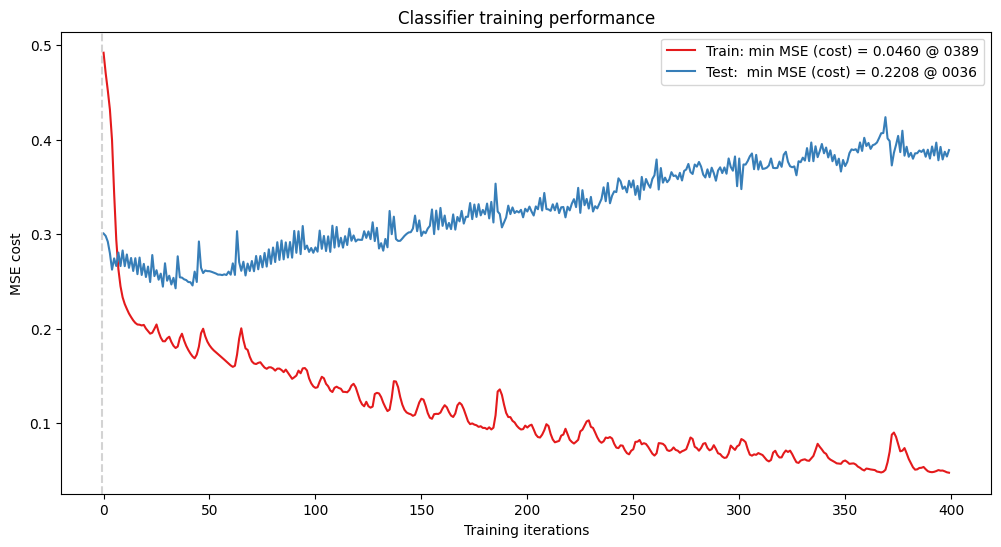

In [32]:
train_label = f'Train: min MSE (cost) = {round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}'
test_label =  f'Test:  min MSE (cost) = {round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}'
multi_plot_series(
    [train_mse_hist, test_mse_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'solid'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='MSE cost',
    legend_cols=1, smooth_weight=0.6, title='Classifier training performance')

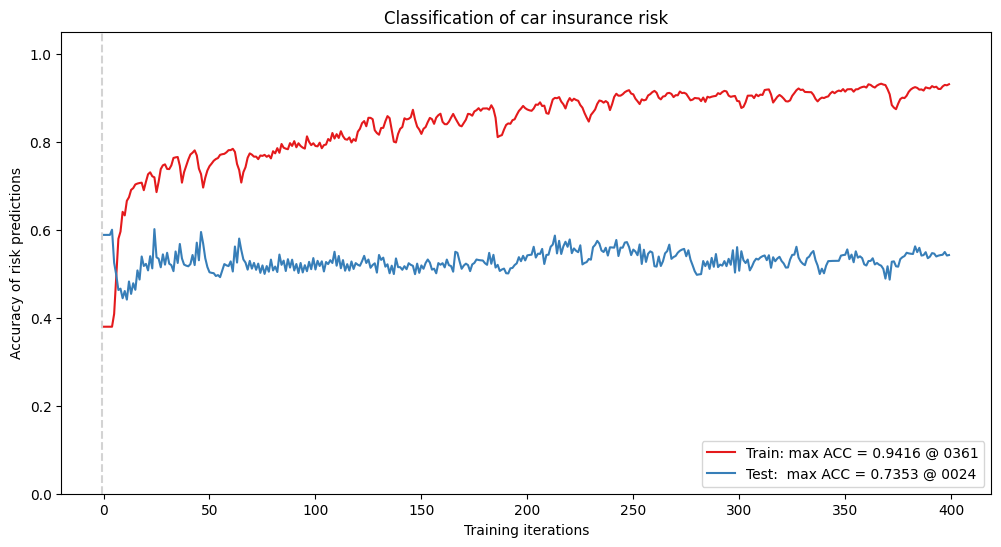

In [33]:
train_label = f'Train: max ACC = {round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}'
test_label =  f'Test:  max ACC = {round(test_max_acc, 5):05.4f} @ {test_max_acc_iter:04d}'
multi_plot_series(
    [train_acc_hist, test_acc_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'solid'], ylim=(0, 1.05), # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='Accuracy of risk predictions',
    legend_cols=1, smooth_weight=0.6, title='Classification of car insurance risk')

---

## Write your observations here

- Task 1:
- Task 2:
- Task 3:
- Task 4:
- Task 5:
- Challenge:
- Reflection:

## Software (Linux)

In [34]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
torch                     2.6.0
torchaudio                2.6.0
torcheval                 0.0.7
torchmetrics              1.6.1
torchsummary              1.5.1
torchvision               0.21.0
